In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.svm import SVC
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.data import AUTOTUNE
from joblib import parallel_backend

In [ ]:
# Directory paths
data_dir = '/content/drive/MyDrive/1. FHNW Classes/2nd Semester/3. Applied Computational Intelligence/Proyecto/brain_tumor'

In [ ]:
valid_df, test_df = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=123)

In [ ]:
# Load and preprocess images
batch_size = 32
img_size = (224, 224)

train_dataset = image_dataset_from_directory(
    directory=os.path.join(data_dir, 'Training'),
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True)

test_dataset = image_dataset_from_directory(
    directory=os.path.join(data_dir, 'Testing'),
    labels='inferred',
    label_mode='int',
    batch_size=batch_size,
    image_size=img_size,
    shuffle=False)

Found 5712 files belonging to 4 classes.
Found 1311 files belonging to 4 classes.


In [ ]:
######### Implement this to the rest of the code ###########
# Load and preprocess images
batch_size = 16
img_size = (224, 224)

train_dataset = image_dataset_from_directory(
    directory=os.path.join(data_dir, 'Training'), labels='inferred', label_mode='int', batch_size=batch_size, image_size=img_size,
    shuffle=True)

test_dataset = image_dataset_from_directory(
    directory=os.path.join(data_dir, 'Testing'), labels='inferred', label_mode='int', batch_size=batch_size, image_size=img_size,
    shuffle=True)

val_dataset = image_dataset_from_directory(
    directory=os.path.join(data_dir, 'Validation'), labels='inferred', label_mode='int', batch_size=batch_size, image_size=img_size,
    shuffle=False)

In [ ]:
# Configure datasets for performance
train_dataset = train_dataset.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# Load pre-trained EfficientNet B0 model
model_path = '/content/drive/MyDrive/1. FHNW Classes/2nd Semester/3. Applied Computational Intelligence/Proyecto/CODIGO BUENO/model_enb0.h5'
pretrained_model = load_model(model_path)

In [ ]:
pretrained_model.summary()

In [ ]:
# Use EfficientNetB0 model as feature extractor
feature_extractor = Model(inputs=pretrained_model.input, outputs=pretrained_model.layers[2].output)

In [ ]:
feature_extractor.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb0_input (Inpu  [(None, 224, 224, 3)]     0         
 tLayer)                                                         
                                                                 
 efficientnetb0 (Functional  (None, 1280)              4049571   
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1280)              5120      
 Normalization)                                                  
                                                                 
 flatten (Flatten)           (None, 1280)              0         
                                                                 
Total params: 4054691 (15.47 MB)
Trainable params: 4010108 (15.30 MB)
Non-trainable params: 44583 (174.16 KB)
_________________

In [ ]:
import time

In [ ]:
# Extract features using batches
def extract_features(dataset):
    start_time = time.time()  # Start time
    all_features = []
    all_labels = []
    for images, labels in dataset:
        features = feature_extractor.predict(images)
        all_features.append(features)
        all_labels.append(labels.numpy())
    all_features = np.concatenate(all_features)
    all_labels = np.concatenate(all_labels)
    end_time = time.time()  # End time
    print(f"Feature extraction took: {end_time - start_time:.2f} seconds")
    return all_features, all_labels

train_features, train_labels = extract_features(train_dataset)
test_features, test_labels = extract_features(test_dataset)

1/1 [==============================] - 4s 4s/step
Feature extraction took: 681.96 seconds
1/1 [==============================] - 2s 2s/step
Feature extraction took: 171.80 seconds


In [ ]:
# Scale features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
test_features = scaler.transform(test_features)

In [ ]:
# Instantiate and train the SVM
svm_classifier = SVC(kernel='rbf', C=1, gamma=0.001, class_weight='balanced')
svm_classifier.fit(train_features, train_labels)

SVC(C=1, class_weight='balanced', gamma=0.001)

In [ ]:
# SVM Classifier with grid search
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 0.001, 0.01],
    'kernel': ['rbf']
}
svm_classifier = GridSearchCV(SVC(class_weight='balanced', probability=True), param_grid, cv=5, verbose=2, n_jobs=-1)

In [ ]:
# Fit SVM
with parallel_backend('threading'):
    svm_classifier.fit(train_features, train_labels)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 1.2min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 1.3min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 1.3min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 1.3min
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time= 1.2min
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time= 1.5min
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time= 1.4min
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time= 1.5min
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time= 1.4min
[CV] END .....................C=0.1, gamma=0.001, kernel=rbf; total time= 1.5min
[CV] END ......................C=0.1, gamma=0.01, kernel=rbf; total time= 4.8min
[CV] END ......................C=0.1, gamma=0.01,

In [ ]:
# Best parameters
best_params = svm_classifier.best_params_
print("Best parameters found:", best_params)

Best parameters found: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}


In [ ]:
# Evaluation
train_predictions = svm_classifier.predict(train_features)
test_predictions = svm_classifier.predict(test_features)

train_accuracy = accuracy_score(train_labels, train_predictions)
test_accuracy = accuracy_score(test_labels, test_predictions)

print(f"Train Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Train Accuracy: 1.0000
Test Accuracy: 0.9847


In [ ]:
# Confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[292   8   0   0]
 [  5 295   3   3]
 [  0   0 405   0]
 [  0   1   0 299]]


In [ ]:
# Sample class names
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Generate the classification report
class_report = classification_report(test_labels, test_predictions, target_names=class_names)
print("Classification Report:\n", class_report)

# Calculate overall accuracy
accuracy = accuracy_score(test_labels, test_predictions)
print(f"Accuracy: {accuracy:.4f}")

# Parse the classification report to extract individual metrics
report_dict = classification_report(test_labels, test_predictions, target_names=class_names, output_dict=True)

# Iterate over each class and print detailed metrics
for class_name in class_names:
    class_metrics = report_dict[class_name]
    print(f"Class: {class_name}")
    print(f" Precision: {class_metrics['precision']:.4f}")
    print(f" Recall: {class_metrics['recall']:.4f}")
    print(f" F1-Score: {class_metrics['f1-score']:.4f}")

Classification Report:
               precision    recall  f1-score   support

      glioma       0.98      0.97      0.98       300
  meningioma       0.97      0.96      0.97       306
     notumor       0.99      1.00      1.00       405
   pituitary       0.99      1.00      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311

Accuracy: 0.9847
Class: glioma
 Precision: 0.9832
 Recall: 0.9733
 F1-Score: 0.9782
Class: meningioma
 Precision: 0.9704
 Recall: 0.9641
 F1-Score: 0.9672
Class: notumor
 Precision: 0.9926
 Recall: 1.0000
 F1-Score: 0.9963
Class: pituitary
 Precision: 0.9901
 Recall: 0.9967
 F1-Score: 0.9934


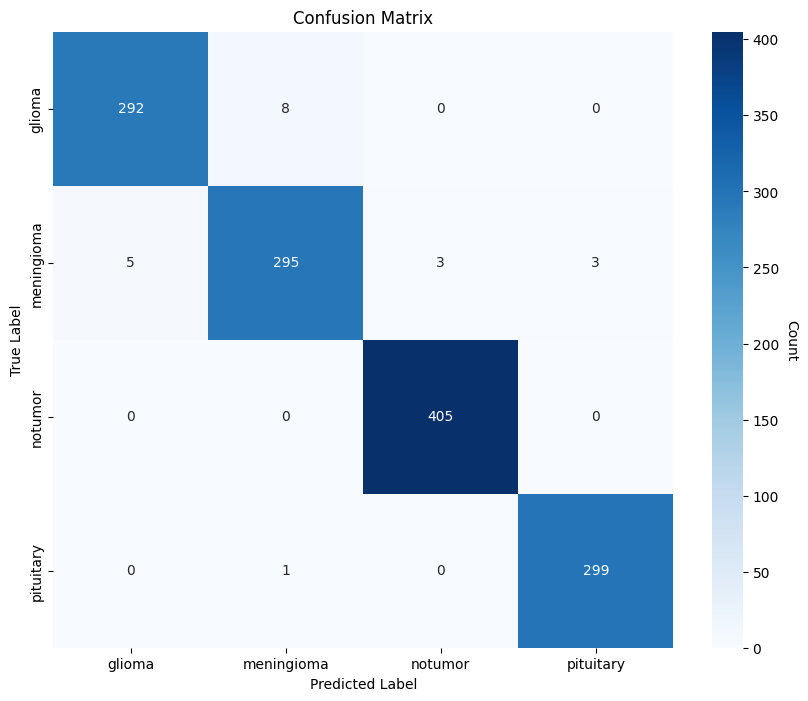

In [ ]:
import seaborn as sns


# Generate the confusion matrix
conf_matrix = confusion_matrix(test_labels, test_predictions)

# Class names for the matrix labels, adjust these as necessary
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']

# Create a DataFrame for easier plotting with seaborn
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', cbar_kws={'label': 'Count'})
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.title('Confusion Matrix')

# Add color bar with the count scale
colorbar = plt.gcf().axes[-1]
colorbar.set_ylabel('Count', rotation=-90, va="bottom")

plt.show()

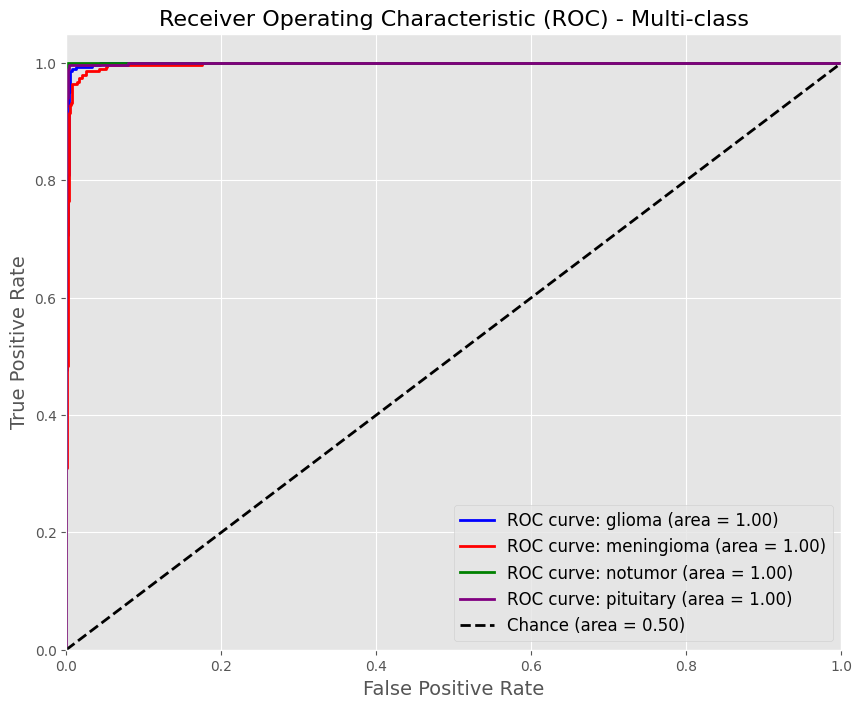

In [ ]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
class_names = ['glioma', 'meningioma', 'notumor', 'pituitary']  # Class names
colors = ['blue', 'red', 'green', 'purple']  # Colors for different ROC curves

plt.figure(figsize=(10, 8))
for i, (color, label) in enumerate(zip(colors, class_names)):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'ROC curve: {label} (area = {roc_auc[i]:.2f})')

# Plot the diagonal line
plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Chance (area = 0.50)')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('Receiver Operating Characteristic (ROC) - Multi-class', fontsize=16)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)  # Optional: Add grid for better readability
plt.show()

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 5712 samples in 0.027s...
[t-SNE] Computed neighbors for 5712 samples in 5.801s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5712
[t-SNE] Computed conditional probabilities for sample 2000 / 5712
[t-SNE] Computed conditional probabilities for sample 3000 / 5712
[t-SNE] Computed conditional probabilities for sample 4000 / 5712
[t-SNE] Computed conditional probabilities for sample 5000 / 5712
[t-SNE] Computed conditional probabilities for sample 5712 / 5712
[t-SNE] Mean sigma: 12.127614
[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.173141
[t-SNE] KL divergence after 300 iterations: 2.219808


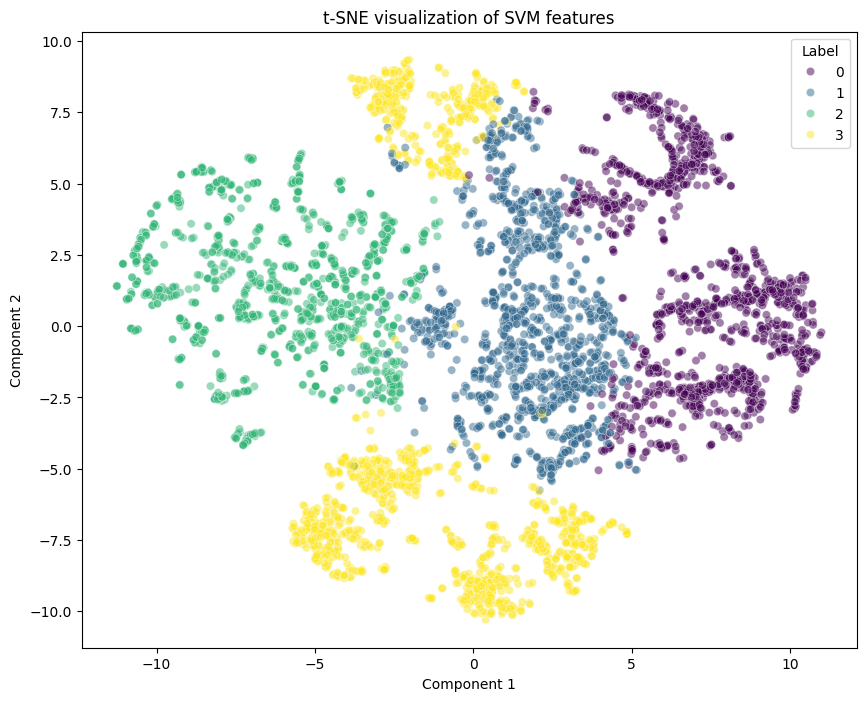

In [ ]:
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)

# Reduce dimensions
tsne_results = tsne.fit_transform(train_features)

# Create a DataFrame for easier plotting
tsne_df = pd.DataFrame({
    'Component 1': tsne_results[:, 0],
    'Component 2': tsne_results[:, 1],
    'Label': train_labels  # Directly use numeric labels
})

# Plotting
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='Component 1', y='Component 2',
    hue='Label',
    palette='viridis',  # Using the 'viridis' color palette
    data=tsne_df,
    legend="full",
    alpha=0.5  # Setting marker transparency to 0.6
)

plt.title('t-SNE visualization of SVM features')
plt.show()